In [1]:
# [1]
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pysimul
from common import *
from math import *

In [2]:
# [2]
reset_type = 'per'
path = "data-2d-periodical-x0var/"
i_beg = 400
i_file = []
param_i = 0

In [3]:
# [3]
simul = pysimul.PySimul()
simul['D'] = D = 1
#simul['reset_rate'] = α = [140**2, 100**2, 70**2, 50**2, 30**2][param_i]
simul['reset_period'] = rT = [0.01, 0.03, 0.07, 0.1][param_i]
simul['xtarg'] = L = 0.1
a = 0.5
b = 2
simul['x0sigma_x'] = σ_x = L / b
aniso = 1
simul['x0sigma_y'] = σ_y = aniso * σ_x
simul['2D-Rtol'] = Rtol = a * L
simul.start()

plot_th_tau = False
if reset_type == 'poisson':
    th_tau_2d = fpt_2d_poisson_tau
    th_c = lambda L: fpt_poisson_c(α, D, L)
elif reset_type == 'per':
    th_tau_2d = fpt_2d_periodical_tau
    th_c = lambda L: fpt_periodic_c(rT, D, L)
param_i += 1
ended = False

In [4]:
# [4]
def timer_f ():
    global simul, ended
    if simul is None:
        return 1
    if simul['n_trajectories'] >= 100000 and not ended:
        ended = True
        return 2
    return 0

In [5]:
%%javascript
var sfml_event_poll_timer = setInterval(function() {
    Jupyter.notebook.kernel.execute("print(timer_f())", { iopub : { output : function (data) {
        console.log(data.content.text)
        if (data.content.text == "1\n" || data.content.text === undefined) {
            clearInterval(sfml_event_poll_timer);
        } else if (data.content.text == "2\n") {
            Jupyter.notebook.execute_cells([7,8,9,3]);
        }
    }}})
}, 4000);

<IPython.core.display.Javascript object>

In [22]:
# [6]
param_i-1, simul['n_trajectories']

(0, 10048)

In [23]:
# [7]
simul.explicit_lock()
Δt = simul['Delta_t']

first_times = simul['first_times']
n_traj = len(first_times)
mfpt = np.mean(first_times)

if i_beg is None: path2 = path+str(i_file[param_i-1])
else:             path2 = path+str(i_beg+param_i-1)
np.savetxt(path2+"-ft.csv", first_times, fmt='%.4e')
d = {
    'D': D,
    'part_m': 0,
    'x0sigma_x': σ_x,
    'x0sigma_y': σ_y,
    'L': L,
    'b': L/σ_x,
    'c': th_c(L),
    'mfpt': mfpt,
    'fpt_stdev': np.std(first_times),
    'n_traj': len(first_times),
    'Delta_t': Δt,
    'Rtol': Rtol,
    'a': a
}
if reset_type == 'poisson':
    d['reset_rate'] = α
elif reset_type == 'per':
    d['reset_period'] = rT

df = pd.DataFrame(list(d.items())).set_index(0)
df.to_csv(path2+"-params.csv", header=False, quoting=csv.QUOTE_NONE, sep=',')
simul.explicit_unlock()
df.T

,D,part_m,x0sigma_x,x0sigma_y,L,b,c,mfpt,fpt_stdev,n_traj,Delta_t,Rtol,a,reset_period
1,1.0,0.0,0.05,0.05,0.1,2.0,0.5,0.011486,0.013691,10107.0,1.000000e-07,0.05,0.5,0.01


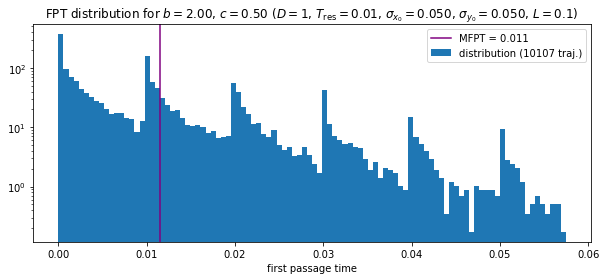

In [24]:
# [8]
c = th_c(L)

plt.figure(figsize=(10,4))
fpt_max = 5*mfpt
plt.hist(first_times, bins=100, range=(0,fpt_max), weights=100/fpt_max*np.ones(n_traj)/n_traj, label="distribution ({} traj.)".format(n_traj))
plt.axvline(x=mfpt, color='purple', label="MFPT = {:.3f}".format(mfpt))
if plot_th_tau:
    mfpt_th = L**2/(4*D)*th_tau_2d(b,c,a)
    plt.axvline(x=mfpt_th, color='black', label="th. MFPT = {:.3f}".format(mfpt_th))
plt.yscale('log')
plt.xlabel("first passage time")
if reset_type == 'poisson':
    plt.title(r"FPT distribution for $b={:.2f}$, $c={:.2f}$ ($D={}$, $\alpha={}$, $\sigma_{{x_0}}={:.3f}$, $\sigma_{{y_0}}={:.3f}$, $L={}$)".format(b, c, D, α, σ_x, σ_y, L))
elif reset_type == 'per':
    plt.title(r"FPT distribution for $b={:.2f}$, $c={:.2f}$ ($D={}$, $T_\operatorname{{res}}={}$, $\sigma_{{x_0}}={:.3f}$, $\sigma_{{y_0}}={:.3f}$, $L={}$)".format(b, c, D, rT, σ_x, σ_y, L))
plt.legend()
plt.savefig(path2+"-distrib.pdf", bbox_inches='tight')

In [62]:
# [9]
simul.end()

In [82]:
simul['pause'] = 0